# Success analysis : finding cofounders 

#### We are interested in conducting an analysis to explore the relationship between the title of a movie and its success. While the title seems to be a crucial aspect since it is a the first hook, it is undoubtable that other factors, such as the cast, director, and movie studio, may exert a more significant influence on a film's success. To gain a comprehensive understanding of the impact of the title, it is essential to analyze potential confounding variables affecting success. In this context, success is measured by both the movie revenue (box office earnings minus budget) and the ratings from IMDb.

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import numpy as np
import string

In [5]:
character_metadata = pd.read_csv('Data/character.metadata.tsv', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'Freebase_movie_ID',
                                                                              'Movie_release_date',
                                                                              'Character_name',
                                                                              'Actor_date_of_birth',
                                                                              'Actor_gender',
                                                                              'Actor_height',
                                                                              'Actor_ethnicity',
                                                                              'Actor_name',
                                                                              'Actor_age_at_movie_release',
                                                                              'Freebase_character/actor_map_ID',
                                                                              'Freebase_character_ID',
                                                                              'Freebase_actor_ID'])

movie_metadata = pd.read_csv('Data/movie.metadata.tsv', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'Freebase_movie_ID',
                                                                              'Movie_name',
                                                                              'Movie_release_date',
                                                                              'Movie_box_office_revenue',
                                                                              'Movie_runtime',
                                                                              'Movie_languages',
                                                                              'Movie_countries',
                                                                              'Movie_genres'])

plot_summaries = pd.read_csv('Data/plot_summaries.txt', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'summary'])

movies = pd.read_csv('Data/movies_metadata_english_only.csv')

In [6]:
movies = pd.read_csv('Data/movies_metadata_english_only.csv')
print('Size of the dataset : ', movies.shape)
movies.dropna(subset=['Movie_box_office_revenue'], inplace=True)
print('Size of the dataset : ', movies.shape)
movies.head()

Size of the dataset :  (25945, 10)
Size of the dataset :  (5821, 10)


,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv..."
4,7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['English Language'],['United States of America'],"['Musical', 'Comedy', 'Black-and-white']"
8,13,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,['English Language'],['United Kingdom'],"['Costume drama', 'War film', 'Epic', 'Period ..."
9,17,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,['English Language'],['United States of America'],"[""Children's/Family"", 'Musical', 'Fantasy', 'C..."
11,21,612710,/m/02wjqm,New Rose Hotel,1999,21521.0,92.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Future noir',..."


In [7]:
# Load the dataframe with Consumer Price indexes (CPI)
# The year of reference is 2012 (latest movie release year)
# Adjust each movie box office with the consumer price indix corresponding to the year of release 

cpi = pd.read_csv('Data/CPI.csv', sep=';')
cpi['Annual'] = cpi['Annual'].str.replace(',', '.')
cpi['Annual'] = pd.to_numeric(cpi['Annual'], errors='coerce')

cpi_value_2012 = cpi.loc[cpi['Year'] == 2012, 'Annual'].values[0] # take 2012 as the reference year for the cpi 

def adjust_inflation_box_office(row):
    year = row['Movie_release_date']
    consumer_price_index = cpi['Annual'][cpi['Year'] == year].values[0]
    revenue_adjusted = row['Movie_box_office_revenue'] * (cpi_value_2012 / consumer_price_index)
    return revenue_adjusted

# Adjust the box office with the inflation
movies['Box_office_adjusted'] = movies.apply(adjust_inflation_box_office, axis=1)
movies.head()

,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Box_office_adjusted
0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",1.816424e+07
4,7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['English Language'],['United States of America'],"['Musical', 'Comedy', 'Black-and-white']",5.862128e+07
8,13,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,['English Language'],['United Kingdom'],"['Costume drama', 'War film', 'Epic', 'Period ...",1.881442e+07
9,17,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,['English Language'],['United States of America'],"[""Children's/Family"", 'Musical', 'Fantasy', 'C...",7.574780e+08
11,21,612710,/m/02wjqm,New Rose Hotel,1999,21521.0,92.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Future noir',...",2.965919e+04


In [8]:
# Load IMDB ratings
ratings_imdb = pd.read_table('Data/ratings_imdb.tsv', sep="\t")
ratings_imdb.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2005
1,tt0000002,5.8,269
2,tt0000003,6.5,1908
3,tt0000004,5.5,178
4,tt0000005,6.2,2688


In [9]:
# import the file with the movies titles ID from imdb
import gdown
import pandas as pd

link_drive = "https://drive.google.com/file/d/1ZkAQhufH1q1a9aJDgs_AzR0hoo2p-LWQ/view?usp=share_link"
id_fichier = link_drive.split("/")[-2]
link_direct = f"https://drive.google.com/uc?id={id_fichier}"
name_file_local = "titles_imdb.tsv"
gdown.download(link_direct, name_file_local, quiet=False)
movie_imdb = pd.read_csv(name_file_local, sep='\t')

unuseful = ['titleType', 'isAdult', 'endYear', 'genres']
movie_imdb.drop(unuseful, axis =1, inplace=True)
movie_imdb.head()


Downloading...
From (uriginal): https://drive.google.com/uc?id=1ZkAQhufH1q1a9aJDgs_AzR0hoo2p-LWQ
From (redirected): https://drive.google.com/uc?id=1ZkAQhufH1q1a9aJDgs_AzR0hoo2p-LWQ&confirm=t&uuid=efc68496-997c-4784-afed-120aa727f42e
To: /Users/blanchekerorgant/Documents/GitHub/2023/2023/ada-2023-project-randada/Projet/titles_imdb.tsv
100%|██████████| 884M/884M [02:22<00:00, 6.22MB/s] 
/var/folders/tn/v_tw25wx0cxgctjg5n0dqd0w0000gn/T/ipykernel_25140/1716720349.py:10: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_imdb = pd.read_csv(name_file_local, sep='\t')


,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes
0,tt0000001,Carmencita,Carmencita,1894,1
1,tt0000002,Le clown et ses chiens,Le clown et ses chiens,1892,5
2,tt0000003,Pauvre Pierrot,Pauvre Pierrot,1892,4
3,tt0000004,Un bon bock,Un bon bock,1892,12
4,tt0000005,Blacksmith Scene,Blacksmith Scene,1893,1


In [10]:
# Load budget info about movies (source : TMDb movies dataset)

budget= pd.read_csv('Data/imdb_budget.csv',sep=",")
budget['date_x']=budget['date_x'].str.strip()
budget['date_x'] = pd.to_datetime(budget['date_x'], format='%m/%d/%Y')
budget['ReleaseYear'] = budget['date_x'].dt.year
unuseful = ['overview', 'status', 'crew', 'orig_lang', 'country', 'score', 'genre', 'orig_title', 'date_x']
budget.drop(unuseful, axis =1, inplace=True)
print(budget.shape)
budget.sample(10)

(10178, 4)


,names,budget_x,revenue,ReleaseYear
1414,The Burning Sea,8300000.0,2836382.0,2022
1933,A Dog's Purpose,22000000.0,205035819.0,2017
9873,Can't Buy Me Love,1800000.0,31623833.0,1987
1701,Casino Royale,102000000.0,594420216.0,2006
3776,Beethoven,9100168.6,147214049.0,1992
8583,Puella Magi Madoka Magica the Movie Part III: ...,33211149.2,12947880.0,2014
1604,Looop Lapeta,69000000.0,133297857.2,2022
8427,Love the Coopers,18000000.0,44263413.0,2015
6608,Eight Legged Freaks,30000000.0,36722311.0,2002
1122,Yu-Gi-Oh!: The Dark Side of Dimensions,9164600.0,1015339.0,2017


In [11]:
# Keep only movies budgets for years comrpised between 1913 ane 2012 (because of the inflation CPI dataset) 

budget = budget[(budget['ReleaseYear'] >= 1913) & (budget['ReleaseYear'] < 2013)]
budget['ReleaseYear'] = budget['ReleaseYear'].astype('int64')

# Adjust movies budgets with inflation with each consumer price index of the year of release 
def adjust_inflation_budget(row):
    year = row['ReleaseYear']
    consumer_price_index = cpi['Annual'][cpi['Year'] == year].values[0]
    revenue_adjusted = row['budget_x'] * (cpi_value_2012 / consumer_price_index)
    return revenue_adjusted

budget['budget_adjusted'] = budget.apply(adjust_inflation_budget, axis=1)
budget.head()


,names,budget_x,revenue,ReleaseYear,budget_adjusted
22,The Passion of the Christ,25000000.0,6.223136e+08,2004,3.038645e+07
58,A Bronx Tale,10000000.0,1.728790e+07,1994,1.549258e+07
61,The Forbidden Legend: Sex & Chopsticks 2,89600000.0,3.183760e+08,2009,9.590751e+07
68,Avatar,237000000.0,2.923706e+09,2009,2.536839e+08
87,Super Mario Bros.,42000000.0,2.084491e+07,1993,6.673495e+07


In [14]:
#load the dataset with the list of famous actors (top 100 from IMdB) and filter the useful columns 

famous_actors= pd.read_csv('Data/famous_actors.csv')
famous_actors.head()
unuseful = ['Description', 'Birth Date', 'Created', 'Modified', 'Known For', 'Position']
famous_actors.drop(unuseful, axis =1, inplace=True)
famous_actors.head()


,Const,Name
0,nm0000134,Robert De Niro
1,nm0000197,Jack Nicholson
2,nm0000008,Marlon Brando
3,nm0000243,Denzel Washington
4,nm0000031,Katharine Hepburn


In [15]:
#clean the movie dataset from imdb

movie_imdb['startYear'] = movie_imdb['startYear'].replace('\\N', np.nan)
movie_imdb['runtimeMinutes'] = movie_imdb['runtimeMinutes'].replace('\\N', np.nan)

movie_imdb.dropna(subset=['startYear'], inplace =True)
movie_imdb.dropna(subset=['runtimeMinutes'], inplace =True)

movie_imdb['startYear']=movie_imdb['startYear'].astype('int')
movie_imdb['runtimeMinutes']=movie_imdb['runtimeMinutes'].astype(int).astype('int')

In [16]:
# merging imdb movies dataset and CMU movies dataset on Movie title, release date and runtime 

merged_movies = movies.merge(movie_imdb,left_on=['Movie_name', 'Movie_release_date', 'Movie_runtime'],right_on=['primaryTitle', 'startYear', 'runtimeMinutes'], how="inner")
print('Size of the new dataset : ', merged_movies.shape)
merged_movies.head()

/var/folders/tn/v_tw25wx0cxgctjg5n0dqd0w0000gn/T/ipykernel_25140/1580238346.py:3: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged_movies = movies.merge(movie_imdb,left_on=['Movie_name', 'Movie_release_date', 'Movie_runtime'],right_on=['primaryTitle', 'startYear', 'runtimeMinutes'], how="inner")


Size of the new dataset :  (2969, 16)


,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Box_office_adjusted,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes
0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",1.816424e+07,tt0228333,Ghosts of Mars,Ghosts of Mars,2001,98
1,7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['English Language'],['United States of America'],"['Musical', 'Comedy', 'Black-and-white']",5.862128e+07,tt0029852,Alexander's Ragtime Band,Alexander's Ragtime Band,1938,106
2,13,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,['English Language'],['United Kingdom'],"['Costume drama', 'War film', 'Epic', 'Period ...",1.881442e+07,tt0097499,Henry V,Henry V,1989,137
3,17,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,['English Language'],['United States of America'],"[""Children's/Family"", 'Musical', 'Fantasy', 'C...",7.574780e+08,tt0058331,Mary Poppins,Mary Poppins,1964,139
4,36,1364293,/m/04wy0v,They Knew What They Wanted,1940,932000.0,96.0,['English Language'],['United States of America'],"['Romance Film', 'Marriage Drama', 'Drama', 'B...",1.528480e+07,tt0033150,They Knew What They Wanted,They Knew What They Wanted,1940,96


In [17]:
#adding the ratings feature, merging on tconst

movies_with_ratings= merged_movies.merge(ratings_imdb, left_on='tconst', right_on='tconst', how='inner')
print('Size of the dataset with the ratings : ', movies_with_ratings.shape)
movies_with_ratings.head()

Size of the dataset with the ratings :  (2967, 18)


,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Box_office_adjusted,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,averageRating,numVotes
0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",1.816424e+07,tt0228333,Ghosts of Mars,Ghosts of Mars,2001,98,4.9,56894
1,7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['English Language'],['United States of America'],"['Musical', 'Comedy', 'Black-and-white']",5.862128e+07,tt0029852,Alexander's Ragtime Band,Alexander's Ragtime Band,1938,106,6.8,2268
2,13,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,['English Language'],['United Kingdom'],"['Costume drama', 'War film', 'Epic', 'Period ...",1.881442e+07,tt0097499,Henry V,Henry V,1989,137,7.5,31193
3,17,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,['English Language'],['United States of America'],"[""Children's/Family"", 'Musical', 'Fantasy', 'C...",7.574780e+08,tt0058331,Mary Poppins,Mary Poppins,1964,139,7.8,181710
4,36,1364293,/m/04wy0v,They Knew What They Wanted,1940,932000.0,96.0,['English Language'],['United States of America'],"['Romance Film', 'Marriage Drama', 'Drama', 'B...",1.528480e+07,tt0033150,They Knew What They Wanted,They Knew What They Wanted,1940,96,6.1,479


In [18]:
# Merging the budget dataset with the preprocessed movies dataset on the movie name and the year of release 

movies_budget_ratings = movies_with_ratings.merge(budget, left_on=['Movie_name', 'Movie_release_date'], right_on=['names', 'ReleaseYear'], how='inner')
print('Size of the dataset with the budget : ', movies_budget_ratings.shape)

# Adding the profit column, with Profit = Box office - Budget 

#movies['budget'] = movies['budget'].astype(float)
#movies['revenue'] = movies['revenue'].astype(float)
movies_budget_ratings['profit'] = movies_budget_ratings['Box_office_adjusted'] - movies_budget_ratings['budget_adjusted']


Size of the dataset with the budget :  (779, 23)


In [23]:
# Normalise the profits and the ratings to have homogenised and comparatible success indicators

success_data= movies_budget_ratings.copy(deep= True)
success_data['Movie_box_office_revenue'].dropna(inplace = True)
print('Size of the dataset with the budget and ratings : ', success_data.shape)

success_data['profit_normalised']= ((success_data['profit']-success_data['profit'].mean())/ success_data['profit'].std())
success_data['averageRating_normalised']= (success_data['averageRating']-success_data['averageRating'].mean())/ success_data['averageRating'].std()


# Create an indicator for success, based on ratings and box office revenues
success_data["success"]= (success_data['averageRating'] + success_data['profit'])/2
success_data.sample(10)




Size of the dataset with the budget and ratings :  (779, 24)


,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,...,numVotes,names,budget_x,revenue,ReleaseYear,budget_adjusted,profit,profit_normalised,averageRating_normalised,success
224,23183,533515,/m/02mgcm,Cat's Eye,1985,13086298.0,94.0,['English Language'],['United States of America'],"['Horror', 'Film adaptation']",...,27554,Cat's Eye,7000000.0,13100000.0,1985,1.493680e+07,1.298712e+07,-0.285288,-0.049535,6.493563e+06
609,65031,12758034,/m/02x3lt7,Hannah Montana: The Movie,2009,155545279.0,102.0,['English Language'],['United States of America'],"[""Children's/Family"", 'Musical comedy', 'Music...",...,44853,Hannah Montana: The Movie,30000000.0,169173206.0,2009,3.211189e+07,1.343832e+08,0.215546,-1.851715,6.719160e+07
84,9849,29471340,/m/0879bpq,Arthur Christmas,2011,147419472.0,97.0,['English Language'],"['United States of America', 'United Kingdom']","['Computer Animation', 'Family Film', 'Comedy'...",...,64178,Arthur Christmas,85000000.0,147865565.0,2011,8.677635e+07,6.372393e+07,-0.075967,0.798549,3.186197e+07
276,28419,11011055,/m/02qy0f5,Flowers in the Attic,1987,15151736.0,93.0,['English Language'],['United States of America'],"['Thriller', 'Mystery', 'Horror', 'Drama', 'Fi...",...,11056,Flowers in the Attic,8280240.6,15151736.0,1987,1.673542e+07,1.388816e+07,-0.281570,-0.685599,6.944084e+06
696,73675,168958,/m/016mng,Friday the 13th,1980,39700000.0,95.0,['English Language'],['United States of America'],"['Cult', 'Horror', 'Slasher', 'Teen']",...,154070,Friday the 13th,550000.0,59754601.0,1980,1.532524e+06,1.090879e+08,0.111187,0.056475,5.454394e+07
773,81387,1443103,/m/051_vd,The Professionals,1966,19537346.0,117.0,['English Language'],['United States of America'],"['Action/Adventure', 'Western', 'Action']",...,18322,The Professionals,65700000.0,658456889.8,1966,4.641452e+08,-3.261214e+08,-1.684319,1.010571,-1.630607e+08
649,69305,666948,/m/0315w4,The Cell,2000,104155843.0,107.0,['English Language'],"['United States of America', 'Germany']","['Thriller', 'Science Fiction', 'Horror', 'Psy...",...,107306,The Cell,35000000.0,104102747.0,2000,4.666667e+07,9.220779e+07,0.041547,0.056475,4.610390e+07
403,43204,28891330,/m/0g56t9t,Frankenweenie,2012,49454000.0,87.0,['English Language'],['United States of America'],"['Science Fiction', 'Horror', 'Stop motion', '...",...,115082,Frankenweenie,39000000.0,81150788.0,2012,3.900000e+07,1.045400e+07,-0.295738,0.586528,5.227003e+06
770,81179,3312138,/m/094zrc,True Crime,1999,16649768.0,127.0,['English Language'],['United States of America'],"['Thriller', 'Crime Fiction', 'Drama', 'Detect...",...,37874,True Crime,55000000.0,16649768.0,1999,7.579832e+07,-5.285242e+07,-0.556916,0.268497,-2.642621e+07
160,17744,30865068,/m/02ml14,Bride of Chucky,1998,50692188.0,89.0,['English Language'],"['United States of America', 'Canada']","['Thriller', 'Horror', 'Supernatural', 'Cult',...",...,63051,Bride of Chucky,25000000.0,50692188.0,1998,3.521472e+07,3.618973e+07,-0.189562,-0.791609,1.809487e+07


In [20]:
# Do famous actors influence the movie rating ?

# Merge movies and character metadata to have access to actors information for each movie, on Wipikedia_movie_ID
movies_and_actors = success_data.merge(character_metadata, on='Wikipedia_movie_ID', how='inner')

# To be considered as famous, an actor has to be in the famous_actors dataset
movies_and_actors['IsFamousActor']=movies_and_actors['Actor_name'].isin(famous_actors['Name'])

# Group movies and actors dataframe by movie and aggregate actors and characters
grouped_movies_actors = movies_and_actors.groupby('Wikipedia_movie_ID').agg({
      'Freebase_movie_ID_x': 'first', 'Movie_name': 'first',
       'Movie_release_date_x': 'first', 'Movie_box_office_revenue': 'first', 'Movie_runtime': 'first',
       'Movie_languages': 'first', 'Movie_countries': 'first', 'Movie_genres': 'first',
       'averageRating': 'first', 'budget_x': 'first', 
       'profit': 'first', 'success': 'first', 
       'Freebase_actor_ID': 'first', 'IsFamousActor': 'first',
    'Actor_name': lambda x: ', '.join(x.dropna()),
    'Character_name': lambda x: ', '.join(x.dropna()),
    'Freebase_character_ID': lambda x: ', '.join(x.dropna())
}).reset_index()
print('Size of the dataset with the actors: ', grouped_movies_actors.shape)

grouped_movies_actors.head()


Index(['Unnamed: 0', 'Wikipedia_movie_ID', 'Freebase_movie_ID_x', 'Movie_name',
       'Movie_release_date_x', 'Movie_box_office_revenue', 'Movie_runtime',
       'Movie_languages', 'Movie_countries', 'Movie_genres',
       'Box_office_adjusted', 'tconst', 'primaryTitle', 'originalTitle',
       'startYear', 'runtimeMinutes', 'averageRating', 'numVotes', 'names',
       'budget_x', 'revenue', 'ReleaseYear', 'budget_adjusted', 'profit',
       'success', 'Freebase_movie_ID_y', 'Movie_release_date_y',
       'Character_name', 'Actor_date_of_birth', 'Actor_gender', 'Actor_height',
       'Actor_ethnicity', 'Actor_name', 'Actor_age_at_movie_release',
       'Freebase_character/actor_map_ID', 'Freebase_character_ID',
       'Freebase_actor_ID', 'IsFamousActor'],
      dtype='object')
Size of the dataset with the actors:  (748, 18)


,Wikipedia_movie_ID,Freebase_movie_ID_x,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,averageRating,budget_x,profit,success,Freebase_actor_ID,IsFamousActor,Actor_name,Character_name,Freebase_character_ID
0,4231,/m/01cbx,Buffy the Vampire Slayer,1992,16624456.0,86.0,['English Language'],['United States of America'],"['Action', 'Horror', 'Comedy', 'Horror Comedy']",-0.685599,7000000.0,-0.273887,-0.479743,/m/0337zp,False,"Kristy Swanson, Donald Sutherland, Paul Reuben...","Buffy Summers, Merrick, Amilyn, Lothos, Pike, ...","/m/0b41h, /m/0h5s5mz, /m/0h5s5p6, /m/0h2n0pr, ..."
1,4728,/m/01hq1,Batman Returns,1992,266822354.0,126.0,['English Language'],"['United States of America', 'United Kingdom']","['Crime Fiction', 'Thriller', 'Superhero movie...",0.798549,80000000.0,0.922472,0.860511,/m/0c4f8m,False,"Cristi Conaway, Michael Gough, Pat Hingle, Jan...","Ice Princess, Alfred Pennyworth, James Gordon,...","/m/0h5rr59, /m/02r129, /m/031v20, /m/0h5rr4q, ..."
2,9835,/m/02p5d,Escape from New York,1981,50000000.0,99.0,['English Language'],"['United States of America', 'United Kingdom']","['Thriller', 'Crime Fiction', 'Science Fiction...",0.798549,6000000.0,0.119643,0.459096,/m/09r5rb,False,"Frank Doubleday, Kurt Russell, Lee Van Cleef, ...","Romero, Snake Plissken, Hauk, Cabbie, Presiden...","/m/0h5twsj, /m/0345b_, /m/0h2y3nn, /m/0h5twr6,..."
3,9979,/m/02qcr,Eyes Wide Shut,1999,162091208.0,159.0,['English Language'],"['United States of America', 'United Kingdom']","['Thriller', 'Erotic Drama', 'Erotica', 'Myste...",1.222592,65000000.0,0.213166,0.717879,/m/0gbzrrl,False,"Mariana Hewett, Tom Cruise, Nicole Kidman, Mad...","Rosa, Bill Harford, Alice Hartford, Helena Har...","/m/0h5pb_4, /m/04jt3h_, /m/04dsqgh, /m/0g9f7s0..."
4,10487,/m/02vhv,Evil Dead II,1987,10900000.0,84.0,['English Language'],['United States of America'],"['Horror', 'Stop motion', 'Cult', 'Comedy', 'S...",1.434613,3500000.0,-0.277163,0.578725,/m/0gby7_x,False,"Richard Domeier, Bruce Campbell, Ted Raimi, Da...","Ed Getley, Ash Williams, Possessed Henrietta, ...","/m/0h608bf, /m/06_krl, /m/0h608c0, /m/0h608b6,..."


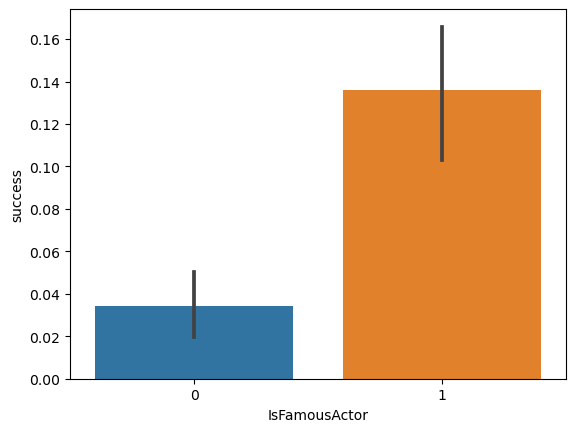

In [21]:
# We are examining the impact of the cast on the success of a movie, aiming to determine whether the presence of renowned actors (IsFamousActor=1) contributes to greater success in a film.

movies_and_actors['IsFamousActor'] = movies_and_actors['IsFamousActor'].astype(int)
ax = sns.barplot(data=movies_and_actors, x=movies_and_actors['IsFamousActor'],y=movies_and_actors['success'])

#est-ce qu'on garde que les films avec un revenue pour l'analyse du succès ? ça réduit beaucoup le dataframe non ? et est-ce qu'on ajuste avec l'inflation ?